In [139]:
##############################
# Diabete Feature Engineering
##############################

# Problem : Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi modeli geliştirilmesi
# istenmektedir. Modeli geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını gerçekleştirmeniz beklenmektedir.

# Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır.
# ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları
# üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır.
# Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

# Pregnancies: Hamilelik sayısı
# Glucose: Glikoz
# BloodPressure: Kan basıncı (Diastolic(Küçük Tansiyon))
# SkinThickness: Cilt Kalınlığı
# Insulin: İnsülin.
# BMI: Beden kitle indeksi.
# DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
# Age: Yaş (yıl)
# Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)


In [140]:
# GÖREV 1: KEŞİFCİ VERİ ANALİZİ
           # Adım 1: Genel resmi inceleyiniz.
           # Adım 2: Numerik ve kategorik değişkenleri yakalayınız.
           # Adım 3:  Numerik ve kategorik değişkenlerin analizini yapınız.
           # Adım 4: Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre numerik değişkenlerin ortalaması)
           # Adım 5: Aykırı gözlem analizi yapınız.
           # Adım 6: Eksik gözlem analizi yapınız.
           # Adım 7: Korelasyon analizi yapınız.

# GÖREV 2: FEATURE ENGINEERING
           # Adım 1:  Eksik ve aykırı değerler için gerekli işlemleri yapınız. Veri setinde eksik gözlem bulunmamakta ama Glikoz, Insulin vb.
           # değişkenlerde 0 değeri içeren gözlem birimleri eksik değeri ifade ediyor olabilir. Örneğin; bir kişinin glikoz veya insulin değeri
           # 0 olamayacaktır. Bu durumu dikkate alarak sıfır değerlerini ilgili değerlerde NaN olarak atama yapıp sonrasında eksik değerlere
           # işlemleri uygulayabilirsiniz.
           # Adım 2: Yeni değişkenler oluşturunuz.
           # Adım 3:  Encoding işlemlerini gerçekleştiriniz.
           # Adım 4: Numerik değişkenler için standartlaştırma yapınız.
           # Adım 5: Model oluşturunuz.

In [141]:
# Gerekli Kütüphane ve Fonksiyonlar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [142]:
df_ = pd.read_csv("/kaggle/input/diabetes-dataset/diabetes.csv")
df = df_.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


# GÖREV 1: KEŞİFCİ VERİ ANALİZİ

# GENEL RESİM

In [143]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35      168 43.100   

   DiabetesPedigreeFunction  Age  Outcome  
0                    

# NUMERİK VE KATEGORİK DEĞİŞKENLERİN YAKALANMASI

In [144]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    
    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [145]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


# KATEGORİK DEĞİŞKENLERİN ANALİZİ

In [146]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                       "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
        
cat_summary(df, "Outcome")

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


# NUMERİK DEĞİŞKENLERİN ANALİZİ

count   768.000
mean      3.845
std       3.370
min       0.000
1%        0.000
5%        0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


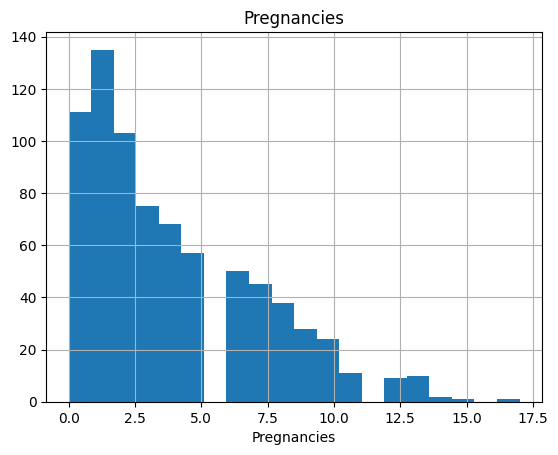

count   768.000
mean    120.895
std      31.973
min       0.000
1%       57.000
5%       79.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


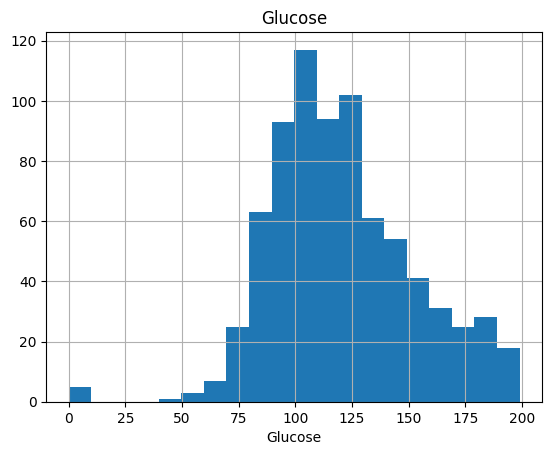

count   768.000
mean     69.105
std      19.356
min       0.000
1%        0.000
5%       38.700
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


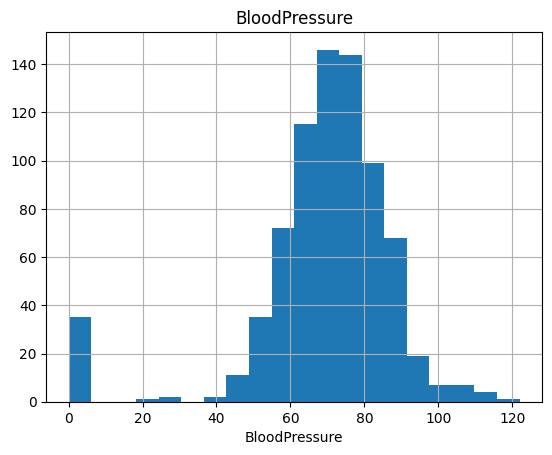

count   768.000
mean     20.536
std      15.952
min       0.000
1%        0.000
5%        0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


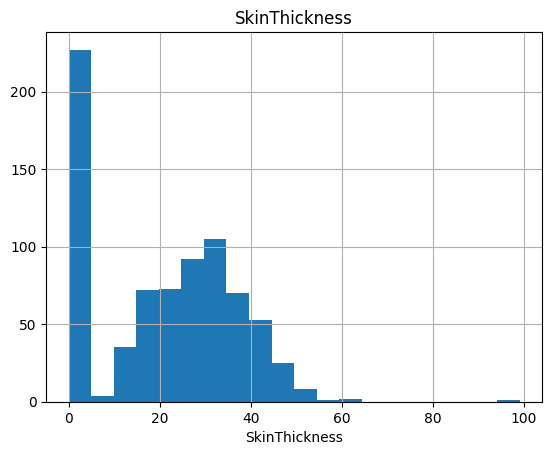

count   768.000
mean     79.799
std     115.244
min       0.000
1%        0.000
5%        0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


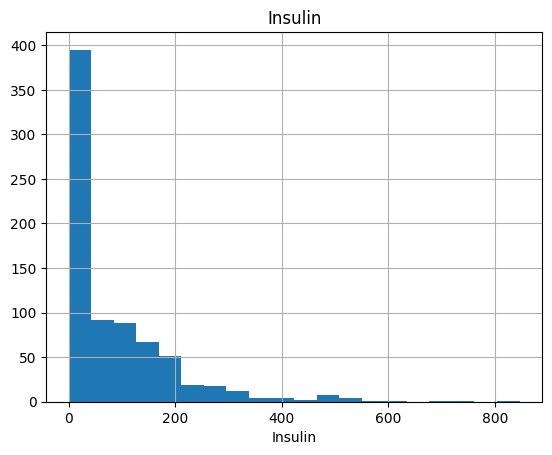

count   768.000
mean     31.993
std       7.884
min       0.000
1%        0.000
5%       21.800
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


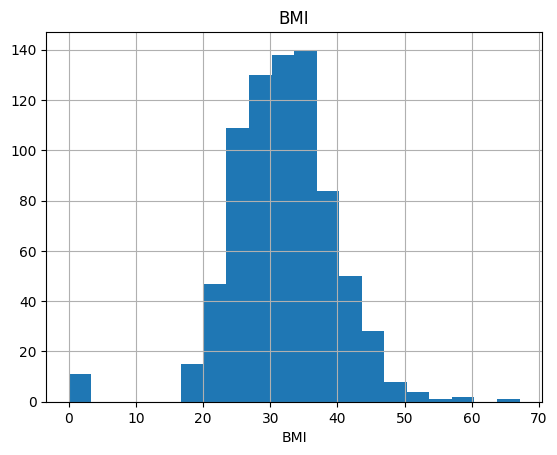

count   768.000
mean      0.472
std       0.331
min       0.078
1%        0.095
5%        0.140
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


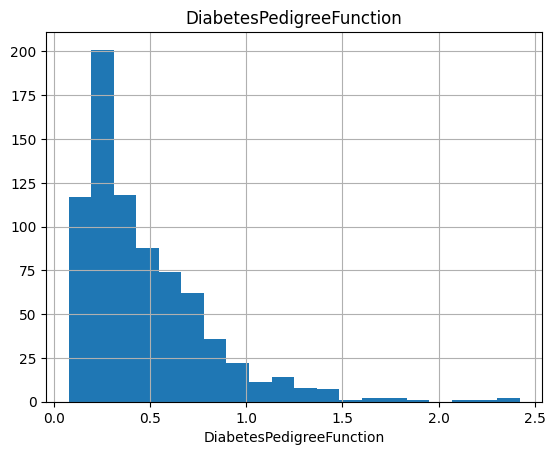

count   768.000
mean     33.241
std      11.760
min      21.000
1%       21.000
5%       21.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


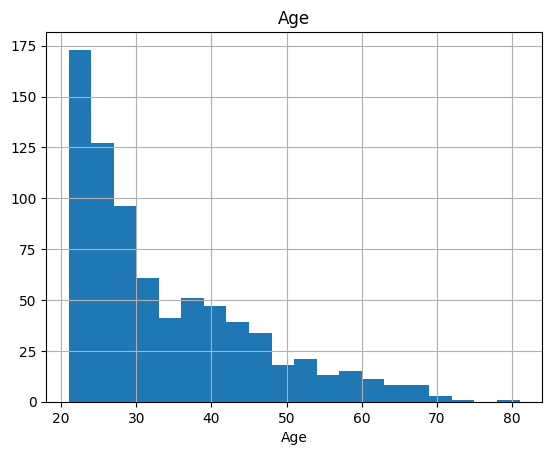

In [147]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.01, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()
        
for col in num_cols:
    num_summary(df, col, True)

# NUMERİK DEĞİŞKENLERİN TARGET GÖRE ANALİZİ

In [148]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end = "\n\n\n")
    
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




# KORELASYON

In [149]:
# Korelasyon, olasılık kuramı ve istatistikte iki rassal değişken arasındaki doğrusal ilişkinin yönünü ve gücünü belirtir

df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


# Korelasyon Matrisi

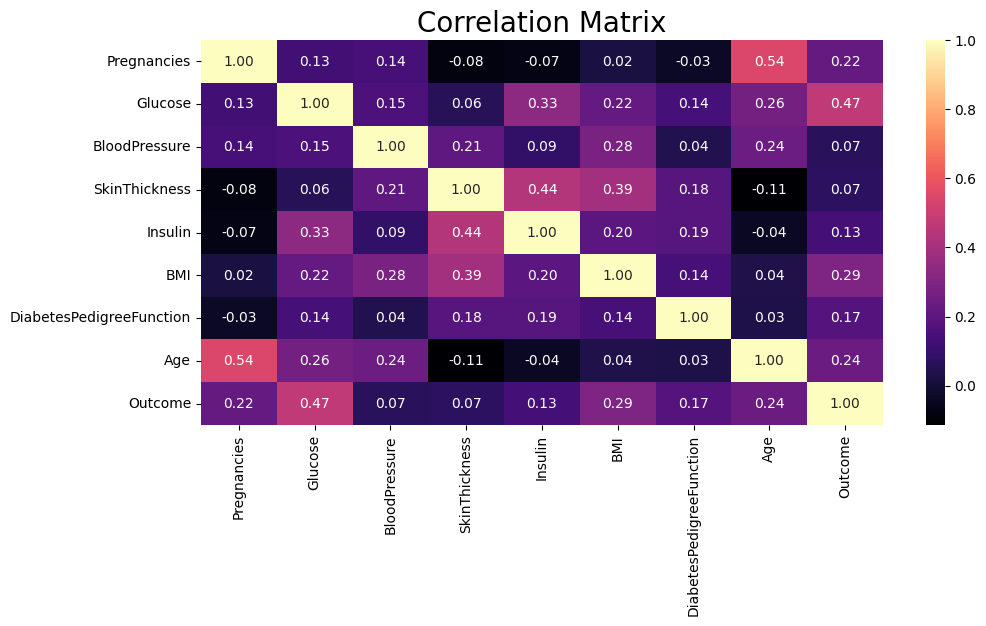

In [150]:
f, ax = plt.subplots(figsize=[11, 5])
sns.heatmap(df.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

# EKSİK DEĞER ANALİZİ

In [151]:
# Bir insanda Pregnancies ve Outcome dışındaki değişken değerleri 0 olamayacağı bilinmektedir.
# Bundan dolayı bu değerlerle ilgili aksiyon kararı alınmalıdır. 0 olan değerlere NaN atanabilir .

zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [152]:
# Gözlem birimlerinde 0 olan degiskenlerin her birisine gidip 0 iceren gozlem degerlerini NaN ile değiştirdik.

for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

In [153]:
# Eksik gözlem analizi
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [154]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


In [155]:
# Eksik Değerlerin Bağımlı Değişken ile İlişkisinin İncelenmesi
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


In [156]:
missing_vs_target(df, "Outcome", na_columns)

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




In [157]:
# Eksik değerlerin doldurulması

for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()

In [158]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

# AYKIRI DEĞER ANALİZİ

In [159]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [160]:
# Aykırı değer analizi ve baskılama işlemi

for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)
        
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False
Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


# GÖREV 2: FEATURE ENGINEERING

In [161]:
# Adım 2: Yeni değişkenler oluşturunuz
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [162]:
# Hamilelik geçirip obez olanlar ve olmayanlar
df.loc[(df["Pregnancies"] > 0) & (df["BMI"] >= 30), "PregnantBMI"] = "PregnantandObesite"
df.loc[(df["Pregnancies"] > 0) & (df["BMI"] < 30), "PregnantBMI"] = "Pregnantandfit"
df.loc[(df["Pregnancies"] == 0) & (df["BMI"] < 30), "PregnantBMI"] = "NotPregnantandfit"
df.loc[(df["Pregnancies"] == 0) & (df["BMI"] >= 30), "PregnantBMI"] = "NotPregnantandObesite"

# Hamile ve glukozu yüksek olanlar ve olmayanlar
df.loc[(df["Pregnancies"] > 0) & (df["Glucose"] >= df["Glucose"].mean()), "PregnantGlucose"] = "PregnantHighG"
df.loc[(df["Pregnancies"] > 0) & (df["Glucose"] < df["Glucose"].mean()), "PregnantGlucose"] = "PregnantLowG"
df.loc[(df["Pregnancies"] == 0) & (df["Glucose"] < df["Glucose"].mean()), "PregnantGlucose"] = "NotPregnantLowG"
df.loc[(df["Pregnancies"] == 0) & (df["Glucose"] >= df["Glucose"].mean()), "PregnantGlucose"] = "NotPregnantHighG"

# Insulin * BMI / SkinThickness
df["IxBMI/ST"] = df["Insulin"] * df["BMI"] / df["SkinThickness"]

# Glucose * BloodPressure / SkinThickness
df["GxBP/ST"] = df["Glucose"] * df["BloodPressure"] / df["SkinThickness"]

# DiabetesPedigreeFunction * Age / IxBMI/ST
df["DPFxAGE/IxBMI/ST"] = df["DiabetesPedigreeFunction"] * df["Age"] / df["IxBMI/ST"]

# Pregnancies / Glucose * log(SkinThickness)
df["P/GxlogST"] = df["Pregnancies"] / df["Glucose"] * np.log(df["SkinThickness"])

# Yaş değişkenini kategorilere ayırıp yeni yaş değişkeni oluşturulması
df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

# BMI 18,5 aşağısı underweight, 18.5 ile 24.9 arası normal, 24.9 ile 29.9 arası Overweight ve 30 üstü obez
df["NEW_BMI"] = pd.cut(x=df["BMI"], bins=[0, 18.5, 24.9, 29.9, 100], labels=["Underweight", "Healthy", "Overweight", "Obese"])

# Glukoz degerini kategorik değişkene çevirme
df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

# Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma 3 kırılım yakalandı
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"

df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"

df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"

df.loc[(df["BMI"] >= 30) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] >= 30) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

# Yaş ve Glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] <50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"

df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"

df.loc[((df["Glucose"] >= 100) & (df["Glucose"] < 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] < 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"

df.loc[(df["Glucose"] >= 125) & ((df["Age"] >= 21) & (df["Age"] <50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] >= 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"

# İnsulin Değeri ile Kategorik değişken türetmek
def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"

df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * (1+ df["Pregnancies"])

# BMI * GLUCOSE
df["BMIXGLUCOSE"] = df["BMI"] * df["Glucose"]

# HOMA-IR (Homeostatic Model Assessment of Insulin Resistance), insülin direncini değerlendirmek için kullanılan bir indekstir ve Glucose (kan şekeri) ile insülin düzeylerine dayalı bir hesaplama ile elde edilir.
# HOMA-IR = (Fasting Insulin (mU/L) x Fasting Glucose (mmol/L)) / 22.5
df["HOMA-IR"] = (df["Insulin"] * df["Glucose"]) / 22.5

# İnsülin Sensitivitesi İndeksi
# İnsülin duyarlılığı indeksi, bir kişinin vücudunun insülini ne kadar iyi kullanabildiğini ölçen bir indekstir. 
# QUICKI = 1 / (log(Insulin μU/mL) + log(Glucose mg/dL))
# QUICKI = 1 / (log(10) + log(90)) ≈ 0.375

df["QUICKI"] = 1 / (np.log(df["Insulin"]) + np.log(df["Glucose"]))

# Kolonların büyültülmesi
df.columns = [col.upper() for col in df.columns]

df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,PREGNANTBMI,PREGNANTGLUCOSE,IXBMI/ST,GXBP/ST,DPFXAGE/IXBMI/ST,P/GXLOGST,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,BMIXGLUCOSE,HOMA-IR,QUICKI
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,PregnantandObesite,PregnantHighG,120.000,304.457,0.261,0.144,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000,1036.000,4972.800,822.222,0.102
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,Pregnantandfit,PregnantLowG,114.655,193.448,0.095,0.040,mature,Overweight,Normal,overweightmature,normalmature,Normal,10625.000,170.000,2261.000,472.222,0.108
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,Pregnantandfit,PregnantHighG,100.431,403.862,0.214,0.147,mature,Healthy,Prediabetes,healthymature,highmature,Normal,22875.000,1647.000,4263.900,1016.667,0.100
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Pregnantandfit,PregnantLowG,114.843,255.391,0.031,0.035,mature,Overweight,Normal,overweightmature,normalmature,Normal,8366.000,178.000,2500.900,371.822,0.111
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,NotPregnantandObesite,NotPregnantHighG,206.880,156.571,0.365,0.000,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.000,137.000,5904.700,1022.933,0.100


# ENCODING

In [163]:
# Değişkenlerin tiplerine göre ayrılması işlemi
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 26
cat_cols: 9
num_cols: 17
cat_but_car: 0
num_but_cat: 3


In [164]:
# LABEL ENCODING
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_col = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

for col in binary_col:
    df = label_encoder(df, col)

In [165]:
# One-Hot Encoding İşlemi
# cat_cols listesinin güncelleme işlemi

cat_cols = [col for col in cat_cols if col not in binary_col and col not in ["OUTCOME"]]

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)


In [166]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,IXBMI/ST,GXBP/ST,DPFXAGE/IXBMI/ST,P/GXLOGST,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,BMIXGLUCOSE,HOMA-IR,QUICKI,PREGNANTBMI_NotPregnantandfit,PREGNANTBMI_PregnantandObesite,PREGNANTBMI_Pregnantandfit,PREGNANTGLUCOSE_NotPregnantLowG,PREGNANTGLUCOSE_PregnantHighG,PREGNANTGLUCOSE_PregnantLowG,NEW_AGE_BMI_NOM_healthysenior,NEW_AGE_BMI_NOM_obesemature,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_overweightmature,NEW_AGE_BMI_NOM_overweightsenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,120.000,304.457,0.261,0.144,1,1,18500.000,1036.000,4972.800,822.222,0.102,False,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,114.655,193.448,0.095,0.040,0,1,10625.000,170.000,2261.000,472.222,0.108,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,100.431,403.862,0.214,0.147,0,1,22875.000,1647.000,4263.900,1016.667,0.100,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,114.843,255.391,0.031,0.035,0,1,8366.000,178.000,2500.900,371.822,0.111,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,206.880,156.571,0.365,0.000,0,0,23016.000,137.000,5904.700,1022.933,0.100,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False


# STANDARTLAŞTIRMA

In [167]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'IXBMI/ST',
 'GXBP/ST',
 'DPFXAGE/IXBMI/ST',
 'P/GXLOGST',
 'NEW_GLUCOSE*INSULIN',
 'NEW_GLUCOSE*PREGNANCIES',
 'BMIXGLUCOSE',
 'HOMA-IR',
 'QUICKI']

In [168]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [169]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,IXBMI/ST,GXBP/ST,DPFXAGE/IXBMI/ST,P/GXLOGST,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,BMIXGLUCOSE,HOMA-IR,QUICKI,PREGNANTBMI_NotPregnantandfit,PREGNANTBMI_PregnantandObesite,PREGNANTBMI_Pregnantandfit,PREGNANTGLUCOSE_NotPregnantLowG,PREGNANTGLUCOSE_PregnantHighG,PREGNANTGLUCOSE_PregnantLowG,NEW_AGE_BMI_NOM_healthysenior,NEW_AGE_BMI_NOM_obesemature,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_overweightmature,NEW_AGE_BMI_NOM_overweightsenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.640,0.866,-0.032,0.680,-0.183,0.167,0.468,1.426,1,-0.394,-0.175,0.650,0.337,1,1,0.024,0.914,0.665,0.024,-0.411,False,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False
1,-0.845,-1.205,-0.528,-0.011,-0.183,-0.852,-0.365,-0.191,0,-0.439,-0.922,-0.162,-0.684,0,1,-0.503,-0.913,-1.182,-0.503,0.418,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False
2,1.234,2.017,-0.694,-0.011,-0.183,-1.333,0.604,-0.106,1,-0.559,0.493,0.420,0.367,0,1,0.317,2.203,0.182,0.317,-0.704,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False
3,-0.845,-1.074,-0.528,-0.702,-0.553,-0.634,-0.921,-1.042,0,-0.438,-0.506,-0.476,-0.726,0,1,-0.654,-0.896,-1.018,-0.654,0.807,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False
4,-1.142,0.504,-2.679,0.680,0.331,1.549,5.485,-0.020,1,0.337,-1.170,1.156,-1.070,0,0,0.326,-0.982,1.299,0.326,-0.713,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False


# MODELLEME

In [171]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.30, random_state=17)

In [172]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [174]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.77
Recall: 0.693
Precision: 0.64
F1: 0.67
Auc: 0.75


In [175]:
# Base Model
# Accuracy: 0.77
# Recall: 0.706
# Precision: 0.59
# F1: 0.64
# Auc: 0.75

    Value                            Feature
16  0.088                        BMIXGLUCOSE
1   0.075                            GLUCOSE
18  0.075                             QUICKI
17  0.075                            HOMA-IR
15  0.066            NEW_GLUCOSE*PREGNANCIES
..    ...                                ...
19  0.001      PREGNANTBMI_NotPregnantandfit
34  0.000      NEW_AGE_GLUCOSE_NOM_lowmature
35  0.000      NEW_AGE_GLUCOSE_NOM_lowsenior
30  0.000  NEW_AGE_BMI_NOM_underweightmature
42  0.000               NEW_GLUCOSE_Diabetes

[43 rows x 2 columns]


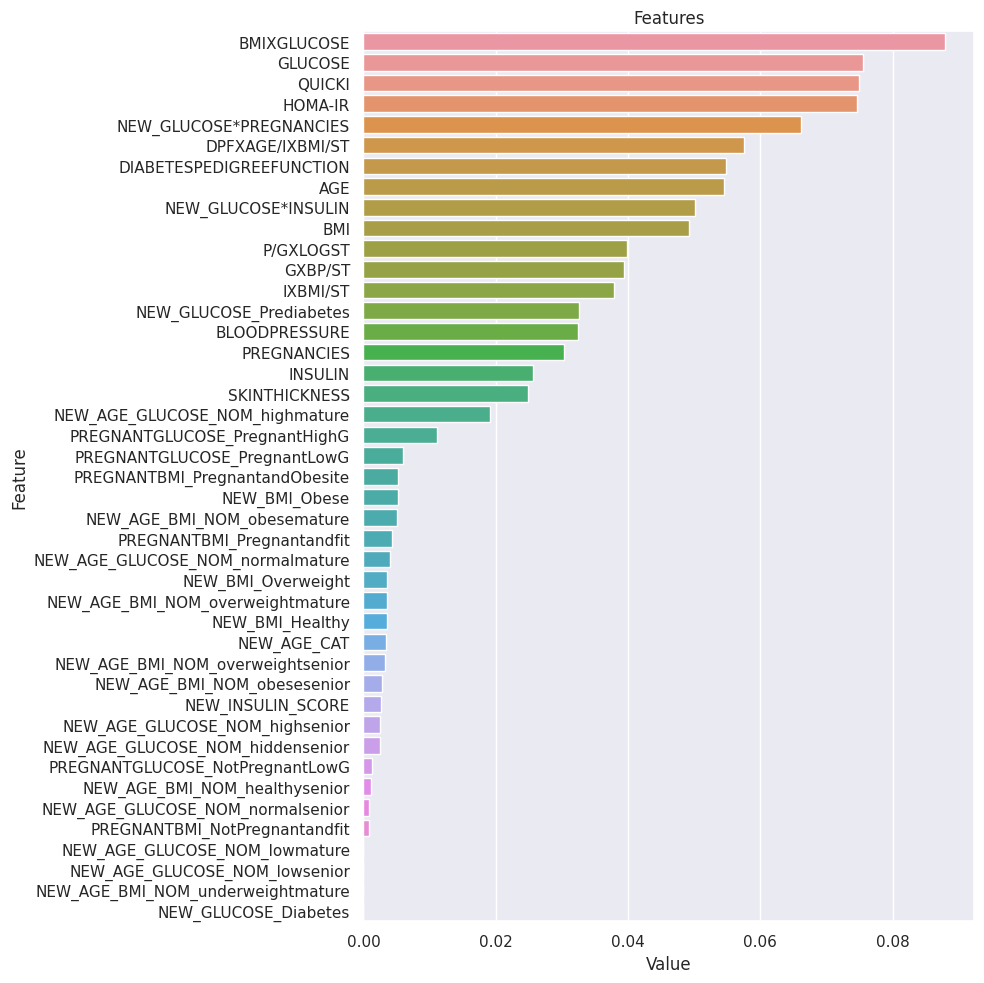

In [176]:
# FEATURE IMPORTANCE

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)